In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pickle as pkl
from sklearn import datasets
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
import skbio
from skbio.stats.composition import clr
from sklearn.model_selection import train_test_split
from skbio.stats.composition import closure, clr
from scipy.stats import gmean
from sklearn.preprocessing import StandardScaler
import imblearn
from imblearn import over_sampling
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler


# Baseline

In [81]:
# Load data
root = Path.cwd().parents[1]
path = root / "data" / "raw" / "full_df_with_meta.csv"
data = pd.read_csv(path)

# Remove entries with missing 'study_condition'
data = data.dropna(subset=['study_condition'])

# Remove carcinoma_surgery_history
data = data[data['study_condition'] != "carcinoma_surgery_history"]

# Create 'healthy' column if person is flagged as control AND has a BMI within the healthy range
data['healthy'] = np.where(
    (data["study_condition"] == "control") & (data["BMI"] >= 18.5) & (data["BMI"] < 25), 1, 0
)

# ---- Partition data 
selected_variables = [
    'age', 'gender', 'country', 'diet', 'smoker', 'ever_smoker', 'alcohol', 'diet'
]

# drop all columns that are not 'healthy' or in the selected_variables list
data = data[[col for col in data.columns if 'healthy' in col or col in selected_variables]]

# One-hot encode categorical variables with 0/1 encoding
categorical_vars = ['gender', 'country', 'diet', 'smoker', 'ever_smoker','alcohol']
demographic_data = pd.get_dummies(data, columns=categorical_vars, drop_first=True, dtype=int)

# Update selected_variables after one-hot encoding
encoded_variables = list(demographic_data.columns)
selected_variables = [var for var in encoded_variables if any(orig_var in var for orig_var in ['age', 'gender', 'country', 'diet', 'smoker', 'alcohol'])]

# Drop rows with any NaN values
data = demographic_data.dropna()

# Scale age column
scaler = StandardScaler()
data['age'] = scaler.fit_transform(data[['age']])

# Split data into features (X) and target (y)
X = data.drop(columns='healthy')
y = data['healthy']

# Split data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42,stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=X_test.shape[0] / X_train.shape[0], random_state=42,stratify=y_train)

# Save the data
datasets = {
    'Training set': (X_train, y_train),
    'Validation set': (X_val, y_val),
    'Test set': (X_test, y_test)
}

output_dir = root / 'data' / 'baseline'
output_dir.mkdir(parents=True, exist_ok=True)

with open(output_dir / 'dataset_distribution.txt', 'w') as file:
    header = "{:<15} | {:>4} | {:>4} | {:>7}".format("Dataset", "1", "0", "Rows")
    file.write(header + '\n')

    for name, (X, y) in datasets.items():
        proportion = y.value_counts(normalize=True)
        total = len(y)
        proportion_1 = proportion.get(1, 0)
        proportion_0 = proportion.get(0, 0)
        line = "{:<15} | {:.2f} | {:.2f} | {:>7}".format(name, proportion_1, proportion_0, total)
        file.write(line + '\n')

# Save CSV files with the specified names
csv_names = ['train.csv', 'val.csv', 'test.csv']
for (X, y), csv_name in zip(datasets.values(), csv_names):
    combined_data = pd.concat([X.reset_index(drop=True), y.reset_index(drop=True)], axis=1)
    combined_data = combined_data.dropna(how='all')  # Ensure no empty rows before saving
    combined_data.to_csv(output_dir / csv_name, index=False)


/var/folders/98/18p7fygn5473lcp5yfrz9s340000gn/T/ipykernel_69623/2728708859.py:4: DtypeWarning: Columns (20,21,22,25,26,28,29,30,31,32,34,37,38,50,51,52,53,54,55,56,61,62,63,64,65,66,67,68,70,82,90,92,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path)


# Baseline undersampled

In [82]:
# Load data
root = Path.cwd().parents[1]
path = root / "data" / "raw" / "full_df_with_meta.csv"
data = pd.read_csv(path)

# Remove entries with missing 'study_condition'
data = data.dropna(subset=['study_condition'])

# Remove carcinoma_surgery_history
data = data[data['study_condition'] != "carcinoma_surgery_history"]

# Create 'healthy' column if person is flagged as control AND has a BMI within the healthy range
data['healthy'] = np.where(
    (data["study_condition"] == "control") & (data["BMI"] >= 18.5) & (data["BMI"] < 25), 1, 0
)

# ---- Partition data 
selected_variables = [
    'age', 'gender', 'country', 'diet', 'smoker', 'ever_smoker', 'alcohol', 'diet'
]

# drop all columns that are not 'healthy' or in the selected_variables list
data = data[[col for col in data.columns if 'healthy' in col or col in selected_variables]]

# One-hot encode categorical variables with 0/1 encoding
categorical_vars = ['gender', 'country', 'diet', 'smoker', 'ever_smoker','alcohol']
demographic_data = pd.get_dummies(data, columns=categorical_vars, drop_first=True, dtype=int)

# Update selected_variables after one-hot encoding
encoded_variables = list(demographic_data.columns)
selected_variables = [var for var in encoded_variables if any(orig_var in var for orig_var in ['age', 'gender', 'country', 'diet', 'smoker', 'alcohol'])]

# Drop rows with any NaN values
data = demographic_data.dropna()

# Scale age column
scaler = StandardScaler()
data['age'] = scaler.fit_transform(data[['age']])

# split data into features (X) and target (y)
X = data[selected_variables]
y = data['healthy']

# Split data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=X_test.shape[0] / X_train.shape[0], random_state=42, stratify=y_train)

# Identify minority class and count
minority_class = y_train.value_counts().idxmin()
minority_count = y_train.value_counts().min()

# Separate majority and minority classes
X_train_minority = X_train[y_train == minority_class]
y_train_minority = y_train[y_train == minority_class]

X_train_majority = X_train[y_train != minority_class]
y_train_majority = y_train[y_train != minority_class]

# Undersample majority class
X_train_majority_downsampled = X_train_majority.sample(n=minority_count, random_state=42)
y_train_majority_downsampled = y_train_majority.sample(n=minority_count, random_state=42)

# Combine the downsampled majority class with the minority class
X_train_balanced = pd.concat([X_train_minority, X_train_majority_downsampled])
y_train_balanced = pd.concat([y_train_minority, y_train_majority_downsampled])

# Save the data
datasets = {
    'Training set': (X_train_balanced, y_train_balanced),
    'Validation set': (X_val, y_val),
    'Test set': (X_test, y_test)
}

output_dir = root / 'data' / 'baseline_undersampled'
output_dir.mkdir(parents=True, exist_ok=True)

# Write dataset distribution
with open(output_dir / 'dataset_distribution.txt', 'w') as file:
    header = "{:<15} | {:>4} | {:>4} | {:>7}".format("Dataset", "1", "0", "Rows")
    file.write(header + '\n')
    
    for name, (X, y) in datasets.items():
        proportion = y.value_counts(normalize=True)
        total = len(y)
        proportion_1 = proportion.get(1, 0)
        proportion_0 = proportion.get(0, 0)
        line = "{:<15} | {:.2f} | {:.2f} | {:>7}".format(name, proportion_1, proportion_0, total)
        file.write(line + '\n')

# Save CSV files
csv_names = ['train.csv', 'val.csv', 'test.csv']
for (X, y), csv_name in zip(datasets.values(), csv_names):
    combined_data = pd.concat([X.reset_index(drop=True), y.reset_index(drop=True)], axis=1)
    combined_data.to_csv(output_dir / csv_name, index=False)


/var/folders/98/18p7fygn5473lcp5yfrz9s340000gn/T/ipykernel_69623/2248741832.py:4: DtypeWarning: Columns (20,21,22,25,26,28,29,30,31,32,34,37,38,50,51,52,53,54,55,56,61,62,63,64,65,66,67,68,70,82,90,92,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path)


# Baseline SMOTE

In [83]:
# Load data
root = Path.cwd().parents[1]
path = root / "data" / "raw" / "full_df_with_meta.csv"
data = pd.read_csv(path)

# Remove entries with missing 'study_condition'
data = data.dropna(subset=['study_condition'])

# Remove carcinoma_surgery_history
data = data[data['study_condition'] != "carcinoma_surgery_history"]

# Create 'healthy' column if person is flagged as control AND has a BMI within the healthy range
data['healthy'] = np.where(
    (data["study_condition"] == "control") & (data["BMI"] >= 18.5) & (data["BMI"] < 25), 1, 0
)

# ---- Partition data 
selected_variables = [
    'age', 'gender', 'country', 'diet', 'smoker', 'ever_smoker', 'alcohol', 'diet'
]

# drop all columns that are not 'healthy' or in the selected_variables list
data = data[[col for col in data.columns if 'healthy' in col or col in selected_variables]]
# One-hot encode categorical variables with 0/1 encoding

categorical_vars = ['gender', 'country', 'diet', 'smoker', 'ever_smoker','alcohol']
demographic_data = pd.get_dummies(data, columns=categorical_vars, drop_first=True, dtype=int)

# Update selected_variables after one-hot encoding
encoded_variables = list(demographic_data.columns)
selected_variables = [var for var in encoded_variables if any(orig_var in var for orig_var in ['age', 'gender', 'country', 'diet', 'smoker', 'alcohol'])]

# Drop rows with any NaN values
data = demographic_data.dropna()

# Scale age column
scaler = StandardScaler()
data['age'] = scaler.fit_transform(data[['age']])

# split data into features (X) and target (y)
X = data[selected_variables]
y = data['healthy']

# Split data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.15, 
                                                    random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=X_test.shape[0] / X_train.shape[0], random_state=42,stratify=y_train)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


# Save the data
datasets = {
    'Training set': (X_train_smote, y_train_smote),
    'Validation set': (X_val, y_val),
    'Test set': (X_test, y_test)
}

output_dir = root / 'data' / 'baseline_smote'
output_dir.mkdir(parents=True, exist_ok=True)

# Write dataset distribution
with open(output_dir / 'dataset_distribution.txt', 'w') as file:
    header = "{:<15} | {:>4} | {:>4} | {:>7}".format("Dataset", "1", "0", "Rows")
    file.write(header + '\n')
    
    for name, (X, y) in datasets.items():
        proportion = y.value_counts(normalize=True)
        total = len(y)
        proportion_1 = proportion.get(1, 0)
        proportion_0 = proportion.get(0, 0)
        line = "{:<15} | {:.2f} | {:.2f} | {:>7}".format(name, proportion_1, proportion_0, total)
        file.write(line + '\n')

# Save CSV files
csv_names = ['train.csv', 'val.csv', 'test.csv']
for (X, y), csv_name in zip(datasets.values(), csv_names):
    combined_data = pd.concat([X.reset_index(drop=True), y.reset_index(drop=True)], axis=1)
    combined_data.to_csv(output_dir / csv_name, index=False)

/var/folders/98/18p7fygn5473lcp5yfrz9s340000gn/T/ipykernel_69623/3506435062.py:4: DtypeWarning: Columns (20,21,22,25,26,28,29,30,31,32,34,37,38,50,51,52,53,54,55,56,61,62,63,64,65,66,67,68,70,82,90,92,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path)


# 50species

In [84]:
# Load data
root = Path.cwd().parents[1]
path = root / "data" / "raw" / "full_df_with_meta.csv"
data = pd.read_csv(path)

# Remove entries with missing 'study_condition'
data = data.dropna(subset=['study_condition'])

# Remove carcinoma_surgery_history
data = data[data['study_condition'] != "carcinoma_surgery_history"]

# Create 'healthy' column if person is flagged as control AND has a BMI within the healthy range
data['healthy'] = np.where(
    (data["study_condition"] == "control") & (data["BMI"] >= 18.5) & (data["BMI"] < 25), 1, 0
)

# Filter away meta data by defining all bacteria columns as containing the string "|" or the outcome variable
bacteria_columns = [col for col in data.columns if '|' in col or 'healthy' in col]
data = data[bacteria_columns]

# For each entry in the bacteria columns, remove all strings that come before the last 's__' but keep 's__', also keeping healthy column
modified_bacteria_columns = [col if col == 'healthy' else 's__' + col.split('s__', 1)[-1] for col in data.columns]
data.columns = modified_bacteria_columns

# Extract each line in the 50_species.txt file and put it in a list
with open("50_species.txt") as f:
    fifty_species = [line.strip() for line in f]

# Define matching columns
matching_columns = [col for col in data.columns if col in fifty_species or col == 'healthy']
data = data[matching_columns]

# Split data into features (X) and target (y)
X = data.drop(columns='healthy')
y = data['healthy']

# Split data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42,stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=X_test.shape[0] / X_train.shape[0], random_state=42,stratify=y_train)

# Save the data
datasets = {
    'Training set': (X_train, y_train),
    'Validation set': (X_val, y_val),
    'Test set': (X_test, y_test)
}

output_dir = root / 'data' / '50SPC'
output_dir.mkdir(parents=True, exist_ok=True)

with open(output_dir / 'dataset_distribution.txt', 'w') as file:
    header = "{:<15} | {:>4} | {:>4} | {:>7}".format("Dataset", "1", "0", "Rows")
    file.write(header + '\n')

    for name, (X, y) in datasets.items():
        proportion = y.value_counts(normalize=True)
        total = len(y)
        proportion_1 = proportion.get(1, 0)
        proportion_0 = proportion.get(0, 0)
        line = "{:<15} | {:.2f} | {:.2f} | {:>7}".format(name, proportion_1, proportion_0, total)
        file.write(line + '\n')

# Save CSV files with the specified names
csv_names = ['train.csv', 'val.csv', 'test.csv']
for (X, y), csv_name in zip(datasets.values(), csv_names):
    combined_data = pd.concat([X.reset_index(drop=True), y.reset_index(drop=True)], axis=1)
    combined_data = combined_data.dropna(how='all')  # Ensure no empty rows before saving
    combined_data.to_csv(output_dir / csv_name, index=False)

/var/folders/98/18p7fygn5473lcp5yfrz9s340000gn/T/ipykernel_69623/196021741.py:4: DtypeWarning: Columns (20,21,22,25,26,28,29,30,31,32,34,37,38,50,51,52,53,54,55,56,61,62,63,64,65,66,67,68,70,82,90,92,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path)


# 50species undersampled

In [85]:
# Load data
root = Path.cwd().parents[1]
path = root / "data" / "raw" / "full_df_with_meta.csv"
data = pd.read_csv(path)

data = data.dropna(subset=['study_condition'])

# Remove carcinoma_surgery_history
data = data[data['study_condition'] != "carcinoma_surgery_history"]

# Create 'healthy' column if person is flagged as control AND has a BMI within the healthy range
data['healthy'] = np.where(
    (data["study_condition"] == "control") & (data["BMI"] >= 18.5) & (data["BMI"] < 25), 1, 0
)

# Filter bacteria columns
bacteria_columns = [col for col in data.columns if '|' in col or 'healthy' in col]
data = data[bacteria_columns]

# Modify bacteria columns
modified_bacteria_columns = [col if col == 'healthy' else 's__' + col.split('s__', 1)[-1] for col in data.columns]
data.columns = modified_bacteria_columns

# Load fifty species
with open("50_species.txt") as f:
    fifty_species = [line.strip() for line in f]

# Filter data to include matching columns
matching_columns = [col for col in data.columns if col in fifty_species or col == 'healthy']
data = data[matching_columns]

# Split data into features and target
X = data.drop(columns='healthy')
y = data['healthy']

# Split data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42,stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=X_test.shape[0] / X_train.shape[0], random_state=42,stratify=y_train)

# Identify minority class and count
minority_class = y_train.value_counts().idxmin()
minority_count = y_train.value_counts().min()

# Separate majority and minority classes
X_train_minority = X_train[y_train == minority_class]
y_train_minority = y_train[y_train == minority_class]

X_train_majority = X_train[y_train != minority_class]
y_train_majority = y_train[y_train != minority_class]

# Undersample majority class
X_train_majority_downsampled = X_train_majority.sample(n=minority_count, random_state=42)
y_train_majority_downsampled = y_train_majority.sample(n=minority_count, random_state=42)

# Combine the downsampled majority class with the minority class
X_train_balanced = pd.concat([X_train_minority, X_train_majority_downsampled])
y_train_balanced = pd.concat([y_train_minority, y_train_majority_downsampled])

# Save the data
datasets = {
    'Training set': (X_train_balanced, y_train_balanced),
    'Validation set': (X_val, y_val),
    'Test set': (X_test, y_test)
}

output_dir = root / 'data' / '50SPC_undersampled'
output_dir.mkdir(parents=True, exist_ok=True)

# Write dataset distribution
with open(output_dir / 'dataset_distribution.txt', 'w') as file:
    header = "{:<15} | {:>4} | {:>4} | {:>7}".format("Dataset", "1", "0", "Rows")
    file.write(header + '\n')
    
    for name, (X, y) in datasets.items():
        proportion = y.value_counts(normalize=True)
        total = len(y)
        proportion_1 = proportion.get(1, 0)
        proportion_0 = proportion.get(0, 0)
        line = "{:<15} | {:.2f} | {:.2f} | {:>7}".format(name, proportion_1, proportion_0, total)
        file.write(line + '\n')

# Save CSV files
csv_names = ['train.csv', 'val.csv', 'test.csv']
for (X, y), csv_name in zip(datasets.values(), csv_names):
    combined_data = pd.concat([X.reset_index(drop=True), y.reset_index(drop=True)], axis=1)
    combined_data.to_csv(output_dir / csv_name, index=False)

/var/folders/98/18p7fygn5473lcp5yfrz9s340000gn/T/ipykernel_69623/2805998996.py:4: DtypeWarning: Columns (20,21,22,25,26,28,29,30,31,32,34,37,38,50,51,52,53,54,55,56,61,62,63,64,65,66,67,68,70,82,90,92,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path)


# 50species SMOTE

In [86]:
# Load data
root = Path.cwd().parents[1]
path = root / "data" / "raw" / "full_df_with_meta.csv"
data = pd.read_csv(path)

# Remove entries with missing 'study_condition'
data = data.dropna(subset=['study_condition'])

# Remove carcinoma_surgery_history
data = data[data['study_condition'] != "carcinoma_surgery_history"]

# Create 'healthy' column if person is flagged as control AND has a BMI within the healthy range
data['healthy'] = np.where(
    (data["study_condition"] == "control") & (data["BMI"] >= 18.5) & (data["BMI"] < 25), 1, 0
)

# Filter away meta data by defining all bacteria columns as containing the string "|" or the outcome variable
bacteria_columns = [col for col in data.columns if '|' in col or 'healthy' in col]
data = data[bacteria_columns]

# For each entry in the bacteria columns, remove all strings that come before the last 's__' but keep 's__', also keeping healthy column
modified_bacteria_columns = [col if col == 'healthy' else 's__' + col.split('s__', 1)[-1] for col in data.columns]
data.columns = modified_bacteria_columns

# Extract each line in the 50_species.txt file and put it in a list
with open("50_species.txt") as f:
    fifty_species = [line.strip() for line in f]

# Define matching columns
matching_columns = [col for col in data.columns if col in fifty_species or col == 'healthy']
data = data[matching_columns]

# Split data into features (X) and target (y)
X = data.drop(columns='healthy')
y = data['healthy']

# Split data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42,stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=X_test.shape[0] / X_train.shape[0], random_state=42,stratify=y_train)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Save the data
datasets = {
    'Training set': (X_train_smote, y_train_smote),
    'Validation set': (X_val, y_val),
    'Test set': (X_test, y_test)
}

output_dir = root / 'data' / '50SPC_smote'
output_dir.mkdir(parents=True, exist_ok=True)

# Write dataset distribution
with open(output_dir / 'dataset_distribution.txt', 'w') as file:
    header = "{:<15} | {:>4} | {:>4} | {:>7}".format("Dataset", "1", "0", "Rows")
    file.write(header + '\n')
    
    for name, (X, y) in datasets.items():
        proportion = y.value_counts(normalize=True)
        total = len(y)
        proportion_1 = proportion.get(1, 0)
        proportion_0 = proportion.get(0, 0)
        line = "{:<15} | {:.2f} | {:.2f} | {:>7}".format(name, proportion_1, proportion_0, total)
        file.write(line + '\n')

# Save CSV files
csv_names = ['train.csv', 'val.csv', 'test.csv']
for (X, y), csv_name in zip(datasets.values(), csv_names):
    combined_data = pd.concat([X.reset_index(drop=True), y.reset_index(drop=True)], axis=1)
    combined_data.to_csv(output_dir / csv_name, index=False)

/var/folders/98/18p7fygn5473lcp5yfrz9s340000gn/T/ipykernel_69623/3282561919.py:4: DtypeWarning: Columns (20,21,22,25,26,28,29,30,31,32,34,37,38,50,51,52,53,54,55,56,61,62,63,64,65,66,67,68,70,82,90,92,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path)


# 50species CLR

In [87]:
# Load data
root = Path.cwd().parents[1]
path = root / "data" / "raw" / "full_df_with_meta.csv"
data = pd.read_csv(path)

# Remove entries with missing 'study_condition'
data = data.dropna(subset=['study_condition'])

# Remove carcinoma_surgery_history
data = data[data['study_condition'] != "carcinoma_surgery_history"]

# Create 'healthy' column if person is flagged as control AND has a BMI within the healthy range
data['healthy'] = np.where(
    (data["study_condition"] == "control") & (data["BMI"] >= 18.5) & (data["BMI"] < 25), 1, 0
)

# Filter away meta data by defining all bacteria columns as containing the string "|" or the outcome variable
bacteria_columns = [col for col in data.columns if '|' in col or 'healthy' in col]
data = data[bacteria_columns]

# For each entry in the bacteria columns, remove all strings that come before the last 's__' but keep 's__', also keeping healthy column
modified_bacteria_columns = [col if col == 'healthy' else 's__' + col.split('s__', 1)[-1] for col in data.columns]
data.columns = modified_bacteria_columns

# Split data into features (X) and target (y)
X = data.drop(columns='healthy')
y = data['healthy']

# Split data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=X_test.shape[0] / X_train.shape[0], random_state=42, stratify=y_train)

# Apply pseudocount to avoid zeros
pseudocount = 1e-6
X_train_pseudocount = X_train + pseudocount
X_val_pseudocount = X_val + pseudocount
X_test_pseudocount = X_test + pseudocount

# Apply CLR transformation
X_train_clr = clr(X_train_pseudocount)
X_val_clr = clr(X_val_pseudocount)
X_test_clr = clr(X_test_pseudocount)

# Convert the CLR transformed data back to DataFrame
X_train_clr = pd.DataFrame(X_train_clr, index=X_train.index, columns=X_train.columns)
X_val_clr = pd.DataFrame(X_val_clr, index=X_val.index, columns=X_val.columns)
X_test_clr = pd.DataFrame(X_test_clr, index=X_test.index, columns=X_test.columns)

# Extract each line in the 50_species.txt file and put it in a list
with open("50_species.txt") as f:
    fifty_species = [line.strip() for line in f]

# Define matching columns
matching_columns = [col for col in X_train_clr.columns if col in fifty_species]

# Filter data to keep only the matching columns
X_train_clr = X_train_clr[matching_columns]
X_val_clr = X_val_clr[matching_columns]
X_test_clr = X_test_clr[matching_columns]

# Recreate datasets with target column
datasets = {
    'Training set': (X_train_clr, y_train),
    'Validation set': (X_val_clr, y_val),
    'Test set': (X_test_clr, y_test)
}

# Save the data
output_dir = root / 'data' / '50SPC_CLR'
output_dir.mkdir(parents=True, exist_ok=True)

with open(output_dir / 'dataset_distribution.txt', 'w') as file:
    header = "{:<15} | {:>4} | {:>4} | {:>7}".format("Dataset", "1", "0", "Rows")
    file.write(header + '\n')

    for name, (X, y) in datasets.items():
        proportion = y.value_counts(normalize=True)
        total = len(y)
        proportion_1 = proportion.get(1, 0)
        proportion_0 = proportion.get(0, 0)
        line = "{:<15} | {:.2f} | {:.2f} | {:>7}".format(name, proportion_1, proportion_0, total)
        file.write(line + '\n')

# Save CSV files with the specified names
csv_names = ['train.csv', 'val.csv', 'test.csv']
for (X, y), csv_name in zip(datasets.values(), csv_names):
    combined_data = pd.concat([X.reset_index(drop=True), y.reset_index(drop=True)], axis=1)
    combined_data = combined_data.dropna(how='all')  # Ensure no empty rows before saving
    combined_data.to_csv(output_dir / csv_name, index=False)

/var/folders/98/18p7fygn5473lcp5yfrz9s340000gn/T/ipykernel_69623/474689622.py:4: DtypeWarning: Columns (20,21,22,25,26,28,29,30,31,32,34,37,38,50,51,52,53,54,55,56,61,62,63,64,65,66,67,68,70,82,90,92,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path)


# 50species CLR undersampled

In [88]:
from skbio.stats.composition import clr

# Load data
root = Path.cwd().parents[1]
path = root / "data" / "raw" / "full_df_with_meta.csv"
data = pd.read_csv(path)

data = data.dropna(subset=['study_condition'])

# Remove carcinoma_surgery_history
data = data[data['study_condition'] != "carcinoma_surgery_history"]

# Create 'healthy' column if person is flagged as control AND has a BMI within the healthy range
data['healthy'] = np.where(
    (data["study_condition"] == "control") & (data["BMI"] >= 18.5) & (data["BMI"] < 25), 1, 0
)

# Filter bacteria columns
bacteria_columns = [col for col in data.columns if '|' in col or 'healthy' in col]
data = data[bacteria_columns]

# Modify bacteria columns
modified_bacteria_columns = [col if col == 'healthy' else 's__' + col.split('s__', 1)[-1] for col in data.columns]
data.columns = modified_bacteria_columns

# Load fifty species
with open("50_species.txt") as f:
    fifty_species = [line.strip() for line in f]

# Filter data to include matching columns
matching_columns = [col for col in data.columns if col in fifty_species or col == 'healthy']
data = data[matching_columns]

# Split data into features and target
X = data.drop(columns='healthy')
y = data['healthy']

# Split data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=X_test.shape[0] / X_train.shape[0], random_state=42, stratify=y_train)

# Apply pseudocount to avoid zeros
pseudocount = 1e-6
X_train_pseudocount = X_train + pseudocount
X_val_pseudocount = X_val + pseudocount
X_test_pseudocount = X_test + pseudocount

# Apply CLR transformation
X_train_clr = clr(X_train_pseudocount)
X_val_clr = clr(X_val_pseudocount)
X_test_clr = clr(X_test_pseudocount)

# Convert the CLR transformed data back to DataFrame
X_train_clr = pd.DataFrame(X_train_clr, index=X_train.index, columns=X_train.columns)
X_val_clr = pd.DataFrame(X_val_clr, index=X_val.index, columns=X_val.columns)
X_test_clr = pd.DataFrame(X_test_clr, index=X_test.index, columns=X_test.columns)

# Identify minority class and count
minority_class = y_train.value_counts().idxmin()
minority_count = y_train.value_counts().min()

# Separate majority and minority classes
X_train_minority = X_train_clr[y_train == minority_class]
y_train_minority = y_train[y_train == minority_class]

X_train_majority = X_train_clr[y_train != minority_class]
y_train_majority = y_train[y_train != minority_class]

# Undersample majority class
X_train_majority_downsampled = X_train_majority.sample(n=minority_count, random_state=42)
y_train_majority_downsampled = y_train_majority.sample(n=minority_count, random_state=42)

# Combine the downsampled majority class with the minority class
X_train_balanced = pd.concat([X_train_minority, X_train_majority_downsampled])
y_train_balanced = pd.concat([y_train_minority, y_train_majority_downsampled])

# Save the data
datasets = {
    'Training set': (X_train_balanced, y_train_balanced),
    'Validation set': (X_val_clr, y_val),
    'Test set': (X_test_clr, y_test)
}

output_dir = root / 'data' / '50SPC_CLR_undersampled'
output_dir.mkdir(parents=True, exist_ok=True)

# Write dataset distribution
with open(output_dir / 'dataset_distribution.txt', 'w') as file:
    header = "{:<15} | {:>4} | {:>4} | {:>7}".format("Dataset", "1", "0", "Rows")
    file.write(header + '\n')
    
    for name, (X, y) in datasets.items():
        proportion = y.value_counts(normalize=True)
        total = len(y)
        proportion_1 = proportion.get(1, 0)
        proportion_0 = proportion.get(0, 0)
        line = "{:<15} | {:.2f} | {:.2f} | {:>7}".format(name, proportion_1, proportion_0, total)
        file.write(line + '\n')

# Save CSV files
csv_names = ['train.csv', 'val.csv', 'test.csv']
for (X, y), csv_name in zip(datasets.values(), csv_names):
    combined_data = pd.concat([X.reset_index(drop=True), y.reset_index(drop=True)], axis=1)
    combined_data.to_csv(output_dir / csv_name, index=False)


/var/folders/98/18p7fygn5473lcp5yfrz9s340000gn/T/ipykernel_69623/3359436497.py:6: DtypeWarning: Columns (20,21,22,25,26,28,29,30,31,32,34,37,38,50,51,52,53,54,55,56,61,62,63,64,65,66,67,68,70,82,90,92,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path)


# 50species CLR SMOTE

In [89]:
# Load data
root = Path.cwd().parents[1]
path = root / "data" / "raw" / "full_df_with_meta.csv"
data = pd.read_csv(path)

data = data.dropna(subset=['study_condition'])

# Remove carcinoma_surgery_history
data = data[data['study_condition'] != "carcinoma_surgery_history"]

# Create 'healthy' column if person is flagged as control AND has a BMI within the healthy range
data['healthy'] = np.where(
    (data["study_condition"] == "control") & (data["BMI"] >= 18.5) & (data["BMI"] < 25), 1, 0
)

# Filter bacteria columns
bacteria_columns = [col for col in data.columns if '|' in col or 'healthy' in col]
data = data[bacteria_columns]

# Modify bacteria columns
modified_bacteria_columns = [col if col == 'healthy' else 's__' + col.split('s__', 1)[-1] for col in data.columns]
data.columns = modified_bacteria_columns

# Load fifty species
with open("50_species.txt") as f:
    fifty_species = [line.strip() for line in f]

# Filter data to include matching columns
matching_columns = [col for col in data.columns if col in fifty_species or col == 'healthy']
data = data[matching_columns]

# Split data into features and target
X = data.drop(columns='healthy')
y = data['healthy']

# Split data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=X_test.shape[0] / X_train.shape[0], random_state=42, stratify=y_train)

# Apply pseudocount to avoid zeros
pseudocount = 1e-6
X_train_pseudocount = X_train + pseudocount
X_val_pseudocount = X_val + pseudocount
X_test_pseudocount = X_test + pseudocount

# Apply CLR transformation
X_train_clr = clr(X_train_pseudocount)
X_val_clr = clr(X_val_pseudocount)
X_test_clr = clr(X_test_pseudocount)

# Convert the CLR transformed data back to DataFrame
X_train_clr = pd.DataFrame(X_train_clr, index=X_train.index, columns=X_train.columns)
X_val_clr = pd.DataFrame(X_val_clr, index=X_val.index, columns=X_val.columns)
X_test_clr = pd.DataFrame(X_test_clr, index=X_test.index, columns=X_test.columns)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_clr, y_train)

# Save the data
datasets = {
    'Training set': (X_train_smote, y_train_smote),
    'Validation set': (X_val_clr, y_val),
    'Test set': (X_test_clr, y_test)
}

output_dir = root / 'data' / '50SPC_CLR_smote'
output_dir.mkdir(parents=True, exist_ok=True)

# Write dataset distribution
with open(output_dir / 'dataset_distribution.txt', 'w') as file:
    header = "{:<15} | {:>4} | {:>4} | {:>7}".format("Dataset", "1", "0", "Rows")
    file.write(header + '\n')
    
    for name, (X, y) in datasets.items():
        proportion = y.value_counts(normalize=True)
        total = len(y)
        proportion_1 = proportion.get(1, 0)
        proportion_0 = proportion.get(0, 0)
        line = "{:<15} | {:.2f} | {:.2f} | {:>7}".format(name, proportion_1, proportion_0, total)
        file.write(line + '\n')

# Save CSV files
csv_names = ['train.csv', 'val.csv', 'test.csv']
for (X, y), csv_name in zip(datasets.values(), csv_names):
    combined_data = pd.concat([pd.DataFrame(X).reset_index(drop=True), pd.DataFrame(y).reset_index(drop=True)], axis=1)
    combined_data.to_csv(output_dir / csv_name, index=False)

/var/folders/98/18p7fygn5473lcp5yfrz9s340000gn/T/ipykernel_69623/4025129916.py:4: DtypeWarning: Columns (20,21,22,25,26,28,29,30,31,32,34,37,38,50,51,52,53,54,55,56,61,62,63,64,65,66,67,68,70,82,90,92,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path)


# CLR PCA LowAbFilt

In [90]:
# Load data
root = Path.cwd().parents[1]
full = root / "data" / "raw" / "full_df_with_meta.csv"
full_df_with_meta = pd.read_csv(full)

full_df_with_meta = full_df_with_meta.dropna(subset=['study_condition'])

# remove carcinoma_surgery_history
full_df_with_meta = full_df_with_meta[full_df_with_meta['study_condition'] != "carcinoma_surgery_history"]

# Create 'healthy' column if person is flagged as control AND has a BMI within the healthy range
full_df_with_meta['healthy'] = np.where(
    (full_df_with_meta["study_condition"] == "control") & (full_df_with_meta["BMI"] >= 18.5) & (full_df_with_meta["BMI"] < 25), 1, 0
)



/var/folders/98/18p7fygn5473lcp5yfrz9s340000gn/T/ipykernel_69623/2071634348.py:4: DtypeWarning: Columns (20,21,22,25,26,28,29,30,31,32,34,37,38,50,51,52,53,54,55,56,61,62,63,64,65,66,67,68,70,82,90,92,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  full_df_with_meta = pd.read_csv(full)


In [91]:
# Get shape of full_df_with_meta
print(f"The number of sample before removing subjects with carcinoma surgery history: {full_df_with_meta.shape}")  # (8261,1585)
# remove the samples with study_condition == carcinoma_surgery_history
full_df_with_meta = full_df_with_meta[full_df_with_meta['study_condition'] != "carcinoma_surgery_history"]
print(f"The number of sample after removing subjects with carcinoma surgery history: {full_df_with_meta.shape}")  # (8221,1585)
print(full_df_with_meta['study_condition'].value_counts())  # 5620 healthy controls, 2641 patients

# get number of unique subject_id
print(f"The number of unique subjects in the data are {len(full_df_with_meta.subject_id.unique())}")  # 8221

# save a .txt file with all the unique values in the study_condition column
with open('study_condition_values.txt', 'w') as f:
    for item in full_df_with_meta['study_condition'].unique():
        f.write("%s\n" % item)

# Make a new column called 'healthy' that is 1 if study_condition == control, 0 if study_condition is not control
full_df_with_meta['healthy'] = np.where(full_df_with_meta["study_condition"] == "control", 1, 0)

disease_counts = full_df_with_meta['study_condition'].value_counts().reset_index()
disease_counts.columns = ['Disease', 'Count']

# Create the structure for the CSV
disease_info = pd.DataFrame({
    'Name': disease_counts['Disease'],
    'Abbreviation': '',
    'Count': disease_counts['Count'],
    'Description': '',
    'Diagnosis': ''
})

# Save the DataFrame to a CSV file
disease_info.to_csv('disease_info.csv', index=False)

The number of sample before removing subjects with carcinoma surgery history: (8221, 1585)
The number of sample after removing subjects with carcinoma surgery history: (8221, 1585)
study_condition
control           5620
CRC                701
IBD                627
IGT                288
adenoma            209
cirrhosis          123
AS                  95
melanoma            86
T2D                 83
schizophrenia       81
STH                 77
ME/CFS              50
migraine            49
cephalosporins      36
CDI                 33
asthma              24
BD                  20
T1D                 19
Name: count, dtype: int64
The number of unique subjects in the data are 6669


/var/folders/98/18p7fygn5473lcp5yfrz9s340000gn/T/ipykernel_69623/3564166705.py:11: DtypeWarning: Columns (20,21,22,25,26,28,29,30,31,32,34,37,38,50,51,52,53,54,55,56,61,62,63,64,65,66,67,68,70,82,90,92,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  full_df_with_meta = pd.read_csv(full)


The number of sample before removing subjects with carcinoma surgery history: (8221, 1585)
The number of sample after removing subjects with carcinoma surgery history: (8221, 1585)
study_condition
control           5620
CRC                701
IBD                627
IGT                288
adenoma            209
cirrhosis          123
AS                  95
melanoma            86
T2D                 83
schizophrenia       81
STH                 77
ME/CFS              50
migraine            49
cephalosporins      36
CDI                 33
asthma              24
BD                  20
T1D                 19
Name: count, dtype: int64
The number of unique subjects in the data are 6669
Cumulative explained variance is: [0.13774266 0.23350677 0.28506082 0.31963613 0.34696982 0.36857746
 0.38852218 0.40492019 0.42023512 0.43500996 0.44928562 0.4629781
 0.47568686 0.48804689 0.49976845 0.51130908 0.5225718  0.53349084
 0.54434395 0.5549639  0.56520425 0.57528249 0.58521464 0.59507038
 0.60457816

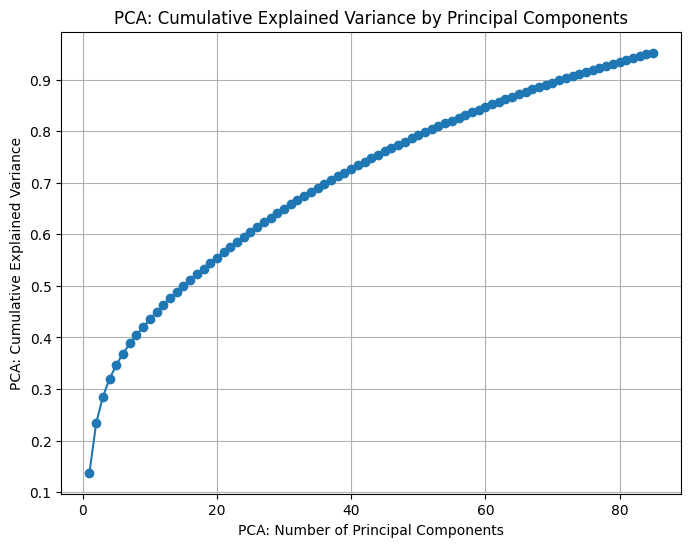

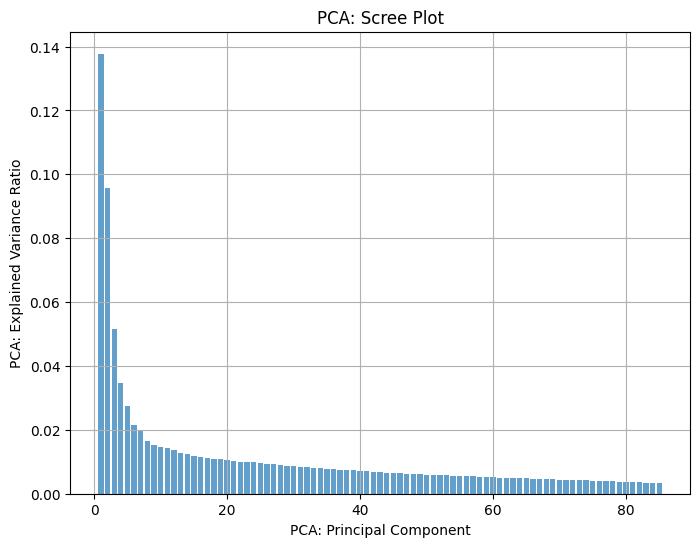

In [93]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Load data
root = Path.cwd().parents[1]
full = root / "data" / "raw" / "full_df_with_meta.csv"
full_df_with_meta = pd.read_csv(full)

full_df_with_meta = full_df_with_meta.dropna(subset=['study_condition'])

# Remove carcinoma_surgery_history
full_df_with_meta = full_df_with_meta[full_df_with_meta['study_condition'] != "carcinoma_surgery_history"]

# Create 'healthy' column if person is flagged as control AND has a BMI within the healthy range
full_df_with_meta['healthy'] = np.where(
    (full_df_with_meta["study_condition"] == "control") & (full_df_with_meta["BMI"] >= 18.5) & (full_df_with_meta["BMI"] < 25), 1, 0
)

# Get shape of full_df_with_meta
print(f"The number of sample before removing subjects with carcinoma surgery history: {full_df_with_meta.shape}")  # (8261,1585)
# Remove the samples with study_condition == carcinoma_surgery_history
full_df_with_meta = full_df_with_meta[full_df_with_meta['study_condition'] != "carcinoma_surgery_history"]
print(f"The number of sample after removing subjects with carcinoma surgery history: {full_df_with_meta.shape}")  # (8221,1585)
print(full_df_with_meta['study_condition'].value_counts())  # 5620 healthy controls, 2641 patients

# Get number of unique subject_id
print(f"The number of unique subjects in the data are {len(full_df_with_meta.subject_id.unique())}")  # 8221

# Save a .txt file with all the unique values in the study_condition column
with open('study_condition_values.txt', 'w') as f:
    for item in full_df_with_meta['study_condition'].unique():
        f.write("%s\n" % item)

disease_counts = full_df_with_meta['study_condition'].value_counts().reset_index()
disease_counts.columns = ['Disease', 'Count']

# Create the structure for the CSV
disease_info = pd.DataFrame({
    'Name': disease_counts['Disease'],
    'Abbreviation': '',
    'Count': disease_counts['Count'],
    'Description': '',
    'Diagnosis': ''
})

# Save the DataFrame to a CSV file
disease_info.to_csv('disease_info.csv', index=False)

# Define all bacteria columns as containing the string "|"
bacteria_columns = [col for col in full_df_with_meta.columns if '|' in col]

# Split data into features (X) and target (y)
X = full_df_with_meta[bacteria_columns]
y = full_df_with_meta['healthy']

# Split data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.15, 
                                                    random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=X_test.shape[0] / X_train.shape[0],  
                                                  random_state=42,stratify=y_train)

# Calculate the sum for each column before CLR
species_columns = [col for col in X_train.columns if '|' in col]
columns_sums = X_train[species_columns].sum()
total_sum = columns_sums.sum()
columns_percentages = (columns_sums / total_sum) * 100

# Find columns where percentage is 0.1% or more
filtered_columns = columns_percentages[columns_percentages >= 0.1].index

# Apply pseudocount to avoid zeros
pseudocount = 1e-6
X_train_pseudocount = X_train + pseudocount
X_val_pseudocount = X_val + pseudocount
X_test_pseudocount = X_test + pseudocount

# Apply CLR transformation
X_train_clr = clr(X_train_pseudocount)
X_val_clr = clr(X_val_pseudocount)
X_test_clr = clr(X_test_pseudocount)

# Convert back to pandas DataFrame
X_train_clr_df = pd.DataFrame(X_train_clr, columns=X_train.columns)
X_val_clr_df = pd.DataFrame(X_val_clr, columns=X_val.columns)
X_test_clr_df = pd.DataFrame(X_test_clr, columns=X_test.columns)

# Filter X_train_clr_df, X_val_clr_df, and X_test_clr_df to include only the relevant columns
X_train_filtered = X_train_clr_df[filtered_columns]
X_val_filtered = X_val_clr_df[filtered_columns]
X_test_filtered = X_test_clr_df[filtered_columns]

# Perform PCA
pca_model = PCA(n_components=0.95)
X_train_pca = pca_model.fit_transform(X_train_filtered)
X_val_pca = pca_model.transform(X_val_filtered)
X_test_pca = pca_model.transform(X_test_filtered)

# Plot cumulative explained variance
cumulative_explained_variance = np.cumsum(pca_model.explained_variance_ratio_)
print(f"Cumulative explained variance is: {cumulative_explained_variance}")

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('PCA: Number of Principal Components')
plt.ylabel('PCA: Cumulative Explained Variance')
plt.title('PCA: Cumulative Explained Variance by Principal Components')
plt.grid(True)
plt.show()

# Scree plot of explained variance ratio
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(pca_model.explained_variance_ratio_) + 1), pca_model.explained_variance_ratio_, alpha=0.7, align='center')
plt.xlabel('PCA: Principal Component')
plt.ylabel('PCA: Explained Variance Ratio')
plt.title('PCA: Scree Plot')
plt.grid(True)
plt.show()

# Save the PCA-transformed data
datasets = {
    'Training set': (X_train_pca, y_train), 
    'Validation set': (X_val_pca, y_val), 
    'Test set': (X_test_pca, y_test)
}
output_dir = root / 'data' / 'CLR_PCA_LowAbFilt'
output_dir.mkdir(parents=True, exist_ok=True)

with open(output_dir / 'dataset_distribution.txt', 'w') as file:
    header = "{:<15} | {:>4} | {:>4} | {:>7}".format("Dataset", "1", "0", "Rows")
    file.write(header + '\n')
    
    for name, (X, y) in datasets.items():
        proportion = y.value_counts(normalize=True)
        total = len(y)
        proportion_1 = proportion.get(1, 0)
        proportion_0 = proportion.get(0, 0)
        line = "{:<15} | {:.2f} | {:.2f} | {:>7}".format(name, proportion_1, proportion_0, total)
        file.write(line + '\n')

# Save CSV files with the specified names
csv_names = ['train.csv', 'val.csv', 'test.csv']
for (X, y), csv_name in zip(datasets.values(), csv_names):
    combined_data = pd.concat([pd.DataFrame(X), y.reset_index(drop=True)], axis=1)
    combined_data.to_csv(output_dir / csv_name, index=False)


# CLR PCA LowAbFilt undersampled

/var/folders/98/18p7fygn5473lcp5yfrz9s340000gn/T/ipykernel_69623/2308555984.py:11: DtypeWarning: Columns (20,21,22,25,26,28,29,30,31,32,34,37,38,50,51,52,53,54,55,56,61,62,63,64,65,66,67,68,70,82,90,92,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  full_df_with_meta = pd.read_csv(full)


Cumulative explained variance is: [0.13494229 0.22933852 0.28270548 0.31617861 0.34251616 0.36361306
 0.38340648 0.4000725  0.41536032 0.43045446 0.44477819 0.45821986
 0.47095155 0.48334502 0.49532593 0.5071455  0.51854613 0.52945008
 0.54026438 0.55101742 0.56160297 0.57183206 0.58185792 0.59147194
 0.60106478 0.61047625 0.61957622 0.62861108 0.63741797 0.64606879
 0.6545463  0.66286698 0.67114103 0.67920778 0.68719883 0.69498118
 0.70265974 0.71018162 0.71752873 0.72475788 0.73191938 0.73884167
 0.74564787 0.75223705 0.75876961 0.76528049 0.77164376 0.77799724
 0.78422058 0.79037289 0.796318   0.80219441 0.80791052 0.81358357
 0.81921325 0.82461194 0.82989124 0.83511689 0.84027963 0.84538963
 0.85046551 0.85550458 0.86034225 0.86510205 0.86977175 0.87441358
 0.87899653 0.88349019 0.88793094 0.89230641 0.89660546 0.90087586
 0.90502115 0.90913158 0.91319318 0.91720032 0.92108605 0.92491935
 0.92874115 0.93249387 0.9362015  0.93976944 0.94331211 0.94671676
 0.9500833 ]


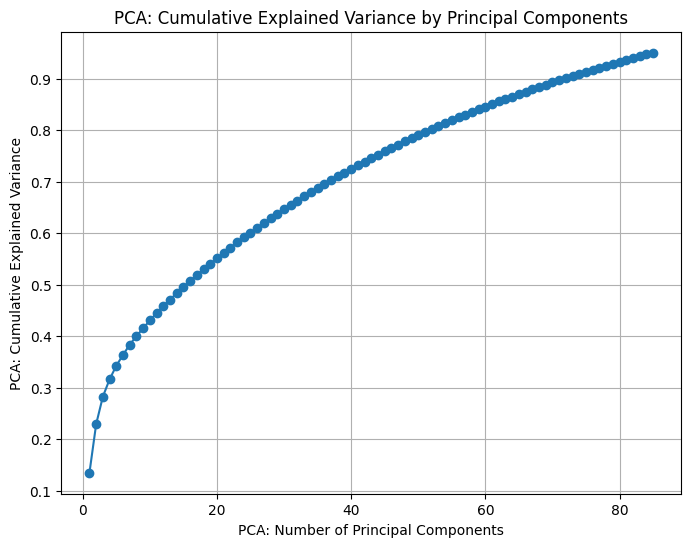

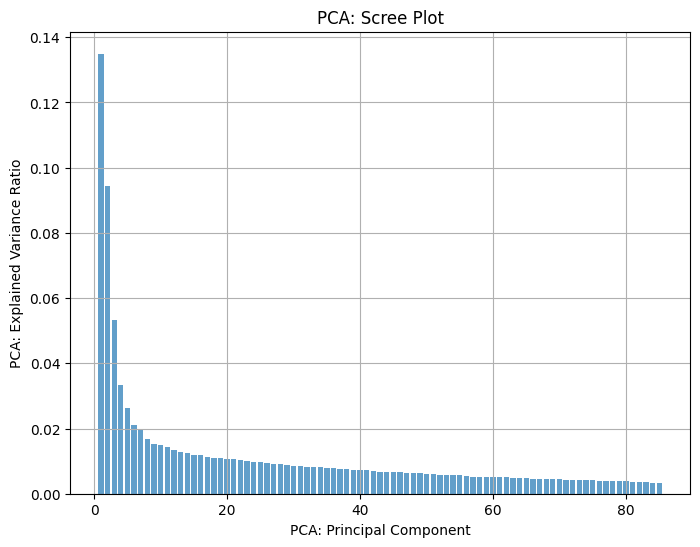

In [97]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from pathlib import Path

# Load data
root = Path.cwd().parents[1]
full = root / "data" / "raw" / "full_df_with_meta.csv"
full_df_with_meta = pd.read_csv(full)

full_df_with_meta = full_df_with_meta.dropna(subset=['study_condition'])

full_df_with_meta['healthy'] = np.where(
    (full_df_with_meta["study_condition"] == "control") & (full_df_with_meta["BMI"] >= 18.5) & (full_df_with_meta["BMI"] < 25), 1, 0)


# Define all bacteria columns as containing the string "|"
bacteria_columns = [col for col in full_df_with_meta.columns if '|' in col]

# Split data into features (X) and target (y)
X = full_df_with_meta[bacteria_columns]
y = full_df_with_meta['healthy']

# Split data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=X_test.shape[0] / X_train.shape[0], random_state=42, stratify=y_train)

# Identify the minority class in the training set
minority_class = y_train.value_counts().idxmin()
minority_count = y_train.value_counts().min()

# Separate the majority and minority classes
X_train_minority = X_train[y_train == minority_class]
y_train_minority = y_train[y_train == minority_class]

X_train_majority = X_train[y_train != minority_class]
y_train_majority = y_train[y_train != minority_class]

# Undersample the majority class
X_train_majority_downsampled = X_train_majority.sample(n=minority_count, random_state=42)
y_train_majority_downsampled = y_train_majority.sample(n=minority_count, random_state=42)

# Combine the downsampled majority class with the minority class
X_train_balanced = pd.concat([X_train_minority, X_train_majority_downsampled])
y_train_balanced = pd.concat([y_train_minority, y_train_majority_downsampled])

# Calculate the sum for each column before CLR
species_columns = [col for col in X_train_balanced.columns if '|' in col]
columns_sums = X_train_balanced[species_columns].sum()
total_sum = columns_sums.sum()
columns_percentages = (columns_sums / total_sum) * 100

# Find columns where percentage is 0.1% or more
filtered_columns = columns_percentages[columns_percentages >= 0.1].index

# Apply pseudocount to avoid zeros
pseudocount = 1e-6
X_train_pseudocount = X_train_balanced + pseudocount
X_val_pseudocount = X_val + pseudocount
X_test_pseudocount = X_test + pseudocount

X_train_clr = clr(X_train_pseudocount)
X_val_clr = clr(X_val_pseudocount)
X_test_clr = clr(X_test_pseudocount)

# Convert back to pandas DataFrame
X_train_clr_df = pd.DataFrame(X_train_clr, columns=X_train.columns)
X_val_clr_df = pd.DataFrame(X_val_clr, columns=X_val.columns)
X_test_clr_df = pd.DataFrame(X_test_clr, columns=X_test.columns)

# Filter X_train_clr_df, X_val_clr_df, and X_test_clr_df to include only the relevant columns
X_train_filtered = X_train_clr_df[filtered_columns]
X_val_filtered = X_val_clr_df[filtered_columns]
X_test_filtered = X_test_clr_df[filtered_columns]

# Perform PCA
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_filtered)
X_val_pca = pca.transform(X_val_filtered)
X_test_pca = pca.transform(X_test_filtered)

# Plot cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
print(f"Cumulative explained variance is: {cumulative_explained_variance}")

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('PCA: Number of Principal Components')
plt.ylabel('PCA: Cumulative Explained Variance')
plt.title('PCA: Cumulative Explained Variance by Principal Components')
plt.grid(True)
plt.show()

# Scree plot of explained variance ratio
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.7, align='center')
plt.xlabel('PCA: Principal Component')
plt.ylabel('PCA: Explained Variance Ratio')
plt.title('PCA: Scree Plot')
plt.grid(True)
plt.show()

# Save the PCA-transformed data
datasets = {
    'Training set': (X_train_pca, y_train_balanced), 
    'Validation set': (X_val_pca, y_val), 
    'Test set': (X_test_pca, y_test)
}
output_dir = root / 'data' / 'CLR_PCA_LowAbFilt_undersampled'
output_dir.mkdir(parents=True, exist_ok=True)

with open(output_dir / 'dataset_distribution.txt', 'w') as file:
    header = "{:<15} | {:>4} | {:>4} | {:>7}".format("Dataset", "1", "0", "Rows")
    file.write(header + '\n')
    
    for name, (X, y) in datasets.items():
        proportion = y.value_counts(normalize=True)
        total = len(y)
        proportion_1 = proportion.get(1, 0)
        proportion_0 = proportion.get(0, 0)
        line = "{:<15} | {:.2f} | {:.2f} | {:>7}".format(name, proportion_1, proportion_0, total)
        file.write(line + '\n')

# Save CSV files with the specified names
csv_names = ['train.csv', 'val.csv', 'test.csv']
for (X, y), csv_name in zip(datasets.values(), csv_names):
    combined_data = pd.concat([pd.DataFrame(X), y.reset_index(drop=True)], axis=1)
    combined_data.to_csv(output_dir / csv_name, index=False)


# CLR PCA LowAbFilt SMOTE

/var/folders/98/18p7fygn5473lcp5yfrz9s340000gn/T/ipykernel_69623/277717072.py:11: DtypeWarning: Columns (20,21,22,25,26,28,29,30,31,32,34,37,38,50,51,52,53,54,55,56,61,62,63,64,65,66,67,68,70,82,90,92,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  full_df_with_meta = pd.read_csv(full)


Cumulative explained variance is: [0.14924002 0.24347217 0.29561768 0.33024566 0.35662363 0.37793127
 0.39616968 0.41325601 0.42842454 0.44258112 0.45645062 0.469667
 0.48198882 0.49416088 0.505991   0.51759267 0.52875073 0.53961317
 0.55023933 0.56065577 0.5707516  0.58079806 0.59068695 0.60031192
 0.60960172 0.61873585 0.62779497 0.63665148 0.64531668 0.65389493
 0.66223226 0.67045903 0.67864649 0.68656718 0.6942858  0.70196665
 0.70958574 0.71707977 0.72427791 0.73145935 0.73850628 0.74538658
 0.75209936 0.75874737 0.76532781 0.7718499  0.77829775 0.78461455
 0.79085044 0.79695882 0.80301809 0.80906093 0.81480346 0.82045725
 0.82600989 0.83153119 0.83689251 0.84218333 0.84738645 0.85256
 0.85758549 0.86247892 0.86724765 0.87200123 0.87673279 0.88135192
 0.88584815 0.89032761 0.89469782 0.89905712 0.90335764 0.90759354
 0.91176353 0.91584789 0.91984752 0.92378072 0.92764707 0.93147035
 0.93519772 0.93882617 0.94240137 0.94585654 0.9492736  0.95254436]


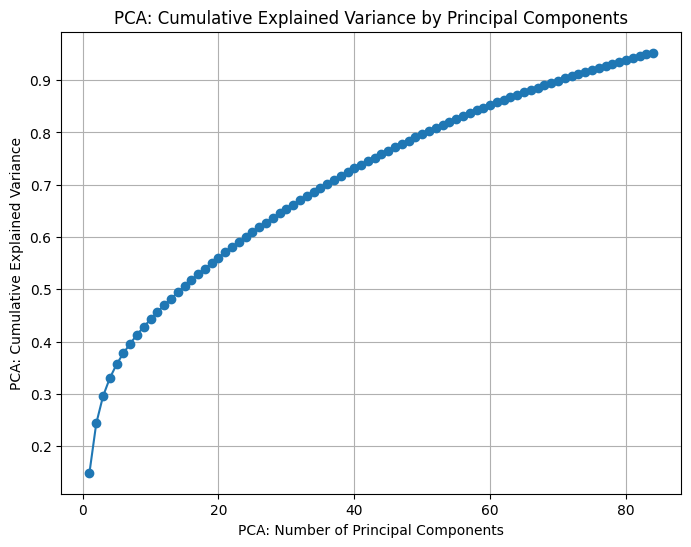

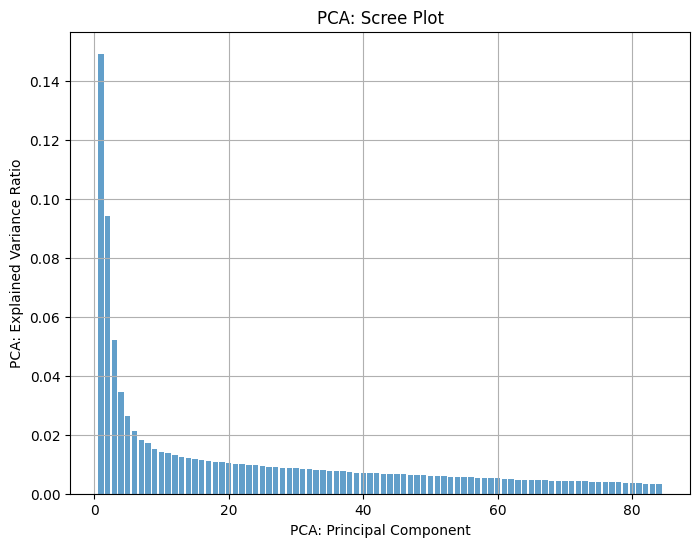

In [98]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from pathlib import Path

# Load data
root = Path.cwd().parents[1]
full = root / "data" / "raw" / "full_df_with_meta.csv"
full_df_with_meta = pd.read_csv(full)

full_df_with_meta = full_df_with_meta.dropna(subset=['study_condition'])

# Make a new column called 'healthy' that is 1 if study_condition == control, 0 if study_condition is not control
full_df_with_meta['healthy'] = np.where(
    (full_df_with_meta["study_condition"] == "control") & (full_df_with_meta["BMI"] >= 18.5) & (full_df_with_meta["BMI"] < 25), 1, 0)


# Define all bacteria columns as containing the string "|"
bacteria_columns = [col for col in full_df_with_meta.columns if '|' in col]

# Split data into features (X) and target (y)
X = full_df_with_meta[bacteria_columns]
y = full_df_with_meta['healthy']

# Split data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=X_test.shape[0] / X_train.shape[0], random_state=42, stratify=y_train)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Calculate the sum for each column before CLR
species_columns = [col for col in X_train_smote.columns if '|' in col]
columns_sums = X_train_smote[species_columns].sum()
total_sum = columns_sums.sum()
columns_percentages = (columns_sums / total_sum) * 100

# Find columns where percentage is 0.1% or more
filtered_columns = columns_percentages[columns_percentages >= 0.1].index

# Apply pseudocount to avoid zeros
pseudocount = 1e-6
X_train_pseudocount = X_train_smote + pseudocount
X_val_pseudocount = X_val + pseudocount
X_test_pseudocount = X_test + pseudocount

X_train_clr = clr(X_train_pseudocount)
X_val_clr = clr(X_val_pseudocount)
X_test_clr = clr(X_test_pseudocount)

# Convert back to pandas DataFrame
X_train_clr_df = pd.DataFrame(X_train_clr, columns=X_train.columns)
X_val_clr_df = pd.DataFrame(X_val_clr, columns=X_val.columns)
X_test_clr_df = pd.DataFrame(X_test_clr, columns=X_test.columns)

# Filter X_train_clr_df, X_val_clr_df, and X_test_clr_df to include only the relevant columns
X_train_filtered = X_train_clr_df[filtered_columns]
X_val_filtered = X_val_clr_df[filtered_columns]
X_test_filtered = X_test_clr_df[filtered_columns]

# Perform PCA
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_filtered)
X_val_pca = pca.transform(X_val_filtered)
X_test_pca = pca.transform(X_test_filtered)

# Plot cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
print(f"Cumulative explained variance is: {cumulative_explained_variance}")

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('PCA: Number of Principal Components')
plt.ylabel('PCA: Cumulative Explained Variance')
plt.title('PCA: Cumulative Explained Variance by Principal Components')
plt.grid(True)
plt.show()

# Scree plot of explained variance ratio
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.7, align='center')
plt.xlabel('PCA: Principal Component')
plt.ylabel('PCA: Explained Variance Ratio')
plt.title('PCA: Scree Plot')
plt.grid(True)
plt.show()

# Save the PCA-transformed data
datasets = {
    'Training set': (X_train_pca, y_train_smote), 
    'Validation set': (X_val_pca, y_val), 
    'Test set': (X_test_pca, y_test)
}
output_dir = root / 'data' / 'CLR_PCA_LowAbFilt_smote'
output_dir.mkdir(parents=True, exist_ok=True)

with open(output_dir / 'dataset_distribution.txt', 'w') as file:
    header = "{:<15} | {:>4} | {:>4} | {:>7}".format("Dataset", "1", "0", "Rows")
    file.write(header + '\n')
    
    for name, (X, y) in datasets.items():
        proportion = y.value_counts(normalize=True)
        total = len(y)
        proportion_1 = proportion.get(1, 0)
        proportion_0 = proportion.get(0, 0)
        line = "{:<15} | {:.2f} | {:.2f} | {:>7}".format(name, proportion_1, proportion_0, total)
        file.write(line + '\n')

# Save CSV files with the specified names
csv_names = ['train.csv', 'val.csv', 'test.csv']
for (X, y), csv_name in zip(datasets.values(), csv_names):
    combined_data = pd.concat([pd.DataFrame(X), y.reset_index(drop=True)], axis=1)
    combined_data.to_csv(output_dir / csv_name, index=False)